In [8]:
import numpy as np
import timeit
import os
import pickle
import ctypes
import scipy
from collections import namedtuple
from PIL import Image, ImageDraw
from itertools import zip_longest

%run utils.ipynb
%run kernel.ipynb

4.75 μs ± 30 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.75 μs ± 52.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
KernelGridStats = namedtuple('KernelGridStats', 'perceive_invokes perceive_invokes_success perceive_success_rate kernels_match_success_rates')
KernelImage = namedtuple('KernelImage', 'image kernel ij')

class FenceKernel(Kernel):
    pass

class KernelGrid:
    def __init__(self, grid_size):
        super()
        self.size = grid_size
        self.fence_kernel = FenceKernel(0) # empty kernel
        self.indices = dict()
        # stats
        self.perceive_invokes = 0
        self.perceive_invokes_success = 0

    def __eq__(self, other): 
        if not isinstance(other, KernelGrid):
            return NotImplemented

        return self.size == other.size and self.indices == other.indices

    @classmethod
    def random_nog(cls, grid_size):
        g = cls(grid_size)
        
        for i in range(g.size):
            for j in range(g.size):
                kernel = Kernel.random_nog(config)
                g.indices[(i, j)] = kernel
                
        return g

    @classmethod
    def random(cls, grid_size, kernel_size):
        g = cls(grid_size)
        
        for i in range(g.size):
            for j in range(g.size):
                kernel = Kernel.random(kernel_size)
                g.indices[(i, j)] = kernel
                
        return g

    @classmethod
    def from_kernels(cls, kernels):
        assert len(kernels) == 2
        assert len(kernels[0]) == len(kernels[1])
        assert len(kernels[0]) > 0

        g = cls(len(kernels[0]))
        
        for i in range(g.size):
            for j in range(g.size):
                kernel = kernels[i][j]
                g.indices[(i, j)] = kernel
                
        return g

    def perceive(self, image, kernel_match_threshold, grid_match_threshold, image_pulps_cache=None):
        self.perceive_invokes += 1
        matched_kernels = 0
        indices_items = self.indices.items()
        
        for ij, k in indices_items:
            image_pulp = None
            
            if image_pulps_cache:
                image_pulp = image_pulps_cache.get(ij)
                
            is_match, match_score = k.match(image, kernel_match_threshold, image_pulp)
            # print(f'kms@ {ij} {is_match} {match_score}')
            matched_kernels += int(is_match)

        match_score = matched_kernels / len(indices_items)

        if match_score > grid_match_threshold:
            self.perceive_invokes_success += 1

        return match_score

    def get_neighbours(self, node_indices):
        def _gn(off_i, off_j):
            neighbour_indices = node_indices[0] + off_i, node_indices[1] + off_j
            
            if any(map(lambda ni: ni < 0 or ni >= self.size, neighbour_indices)):
                # print(f'kms@ fence {neighbour_indices}')
                return neighbour_indices, self.fence_kernel

            # print('kms@ normal')
            return neighbour_indices, self.indices[neighbour_indices]

        # Order: l, lt, t, rt, r, rb, b, lb
        return (\
            _gn(-1, 0),
            _gn(-1, 1),
            _gn(0, 1),
            _gn(1, 1),
            _gn(0, 1),
            _gn(1, -1),
            _gn(0, -1),
            _gn(-1, -1)
        )

    def get_kernel_images(self, out_dims=1):
        assert out_dims in [1, 2]
        images = []
        
        for i in range(self.size):
            acc = [] if out_dims == 2 else images
            
            for j in range(self.size):
                k = self.indices[(i,j)]
                ki = KernelImage(
                    kernel=k,
                    ij=(i,j),
                    image=k.to_image(inverted=False)
                )
                acc.append(ki)

            if out_dims == 2:
                images.append(acc)

        return images

    # def enhance(self, extinct_waterline):
    #     assert extinct_waterline > 0 and extinct_waterline < 1

    #     k_perf_scores = []

    #     for ij, k in self.indices.items():
    #         k_perf_score = k.match_invokes_success / k.match_invokes
    #         k_perf_scores.append((k_perf_score, k, ij))

    #     k_perf_scores = k_perf_scores.sort(key=lambda x: x[0])
    #     extinct_list = k_perf_scores[0:len(k_perf_scores) * extinct_waterline]
    #     assert len(extinct_list) < len(k_perf_scores)

    #     for k_perf_score, k, ij in extinct_list:
    #         pass        

    def get_stats(self):
        kernels_stats = [k.get_stats().match_success_rate for k in self.indices.values()]
        
        return KernelGridStats(
            perceive_invokes=self.perceive_invokes,
            perceive_invokes_success=self.perceive_invokes_success,
            perceive_success_rate=0 if self.perceive_invokes == 0 else self.perceive_invokes_success / self.perceive_invokes,
            kernels_match_success_rates=scipy.stats.describe(kernels_stats)
        )

    def reset_stats(self):
        self.perceive_invokes = 0
        self.perceive_invokes_success = 0

        for _, k in self.indices.items():
            k.reset_stats()

In [10]:
my_config = Config()
m_data = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.uint8)
horz_line_kernel = Kernel.from_m_data_nog(m_data)
shifted_horz_line_kernel = Kernel.from_m_data_nog(np.roll(m_data, -3, axis=0))
vert_line_kernel = Kernel.from_m_data_nog(m_data.T)
vert_line_kernel.match(vert_line_image, my_config.kernel_match_threshold)
shifted_vert_line_kernel = Kernel.from_m_data_nog(np.roll(m_data.T, -3, axis=1))

kernels1 = [
    [horz_line_kernel, shifted_horz_line_kernel],
    [vert_line_kernel, shifted_vert_line_kernel],
]
kernels2 = [
    [vert_line_kernel, shifted_vert_line_kernel],
    [horz_line_kernel, shifted_horz_line_kernel],
]
grid1 = KernelGrid.from_kernels(kernels1)
grid2 = KernelGrid.from_kernels(kernels2)
assert grid1 != grid2
grid1_ser = pickle.dumps(grid1)
grid1_loaded = pickle.loads(grid1_ser)
assert grid1 == grid1_loaded

In [11]:
m_data = np.array([
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
], dtype=np.uint8)
kernels = [
    [ Kernel.from_m_data_nog(m_data), Kernel.from_m_data_nog(m_data.T) ],
    [ Kernel.from_m_data_nog(np.roll(m_data, 4, axis=1)), Kernel.from_m_data_nog(np.roll(m_data.T, 4, axis=0)) ]
]
grid = KernelGrid.from_kernels(kernels)
assert grid.perceive_invokes == 0
assert grid.perceive_invokes_success == 0

vert_bar_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(vert_bar_image)
draw.rectangle([0, 0, 3, 7], 255)

center_rect_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(center_rect_image)
draw.rectangle([2, 2, 5, 5], 255)

match_score = grid.perceive(vert_bar_image, 0.5, 0.25 - np.finfo(float).eps)
assert match_score == 0.25, match_score
assert grid.perceive_invokes == 1
assert grid.perceive_invokes_success == 1

match_score = grid.perceive(center_rect_image, 0.5, 0.25)
assert grid.perceive_invokes == 2
assert grid.perceive_invokes_success == 1

match_score = grid.perceive(vert_bar_image, 0.5, 0.5)
assert grid.perceive_invokes == 3
assert grid.perceive_invokes_success == 1
grid_stats = grid.get_stats()
assert grid_stats.kernels_match_success_rates.minmax == (0, 2/3)
assert grid_stats.kernels_match_success_rates.mean == (2/3 + 0 + 0 + 0) /4

grid.reset_stats()
assert grid.perceive_invokes == 0
assert grid.perceive_invokes_success == 0


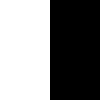
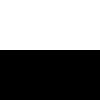
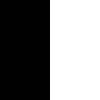
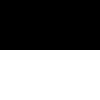

In [12]:
kernel_images = [i.image.resize((100, 100)) for i in grid.get_kernel_images(1)]
display_images_grid(kernel_images, grid.size)


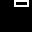
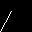
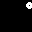
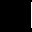
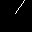
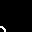
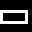
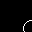
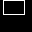
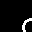
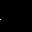
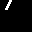
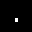
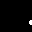
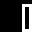
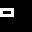
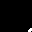
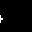
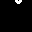
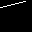
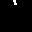
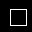
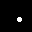
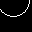
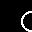
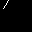
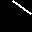
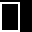
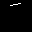
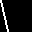
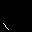
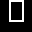
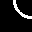
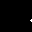
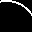
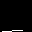
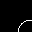
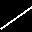
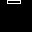
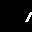
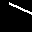
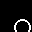
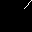
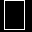
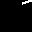
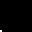
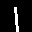
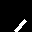
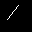
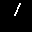
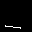
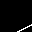
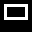
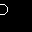
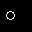
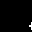
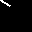
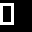
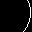
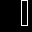
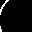
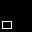
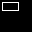
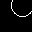
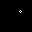
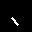
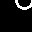
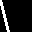
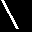
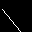
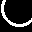
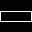
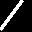
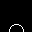
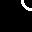
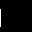
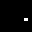
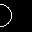
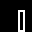
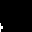
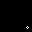
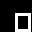
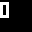
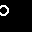
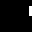
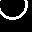
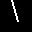
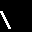
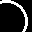
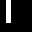
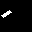
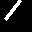
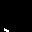
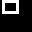
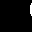
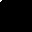
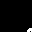
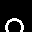
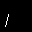
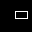
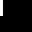
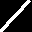
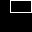
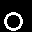
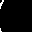
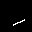
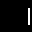
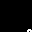
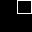
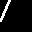
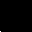
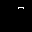
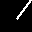
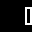
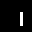
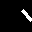
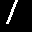
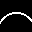
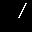
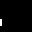
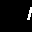
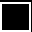
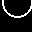
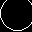
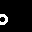
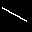
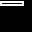
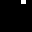
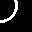
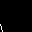
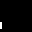
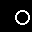
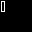
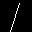
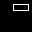
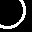
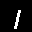
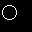
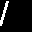
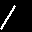
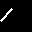
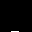
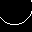
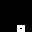
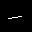
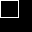
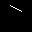
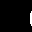
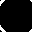
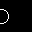
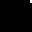
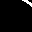
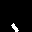
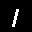
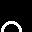
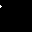
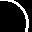
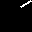
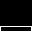
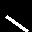
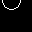
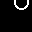
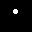
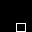
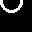
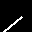
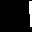
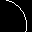
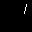
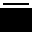
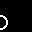
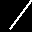
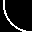
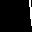
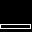
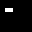
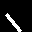
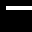
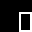
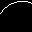
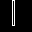
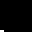
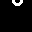
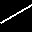
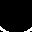
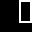
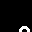
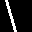
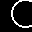
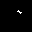
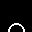
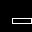
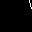
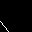
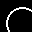
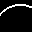
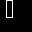
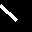
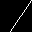
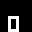
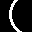
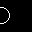
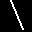
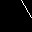
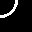
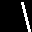
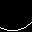
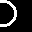
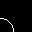
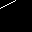
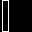
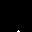
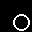
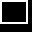
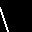
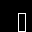
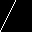
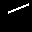
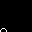
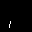
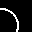
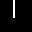
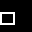
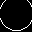
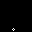
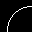
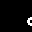
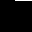
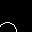
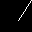
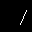
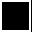
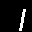
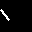
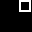
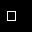
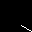
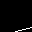
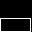
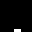
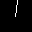
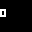
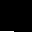
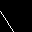
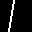
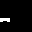
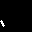
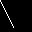
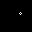
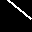
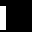
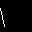
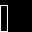
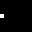
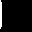
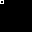

In [13]:
my_config = Config()
grid = KernelGrid.random(my_config.kernel_grid_size, my_config.kernel_size)
kernel_images = grid.get_kernel_images(1)
display_images_grid([ki.image for ki in kernel_images], grid.size)

In [14]:
m_data = np.array([
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [1, 1, 0, 0],
], dtype=np.uint8)
kernels = [
    [ Kernel.from_m_data_nog(m_data), Kernel.from_m_data_nog(m_data.T) ],
    [ Kernel.from_m_data_nog(np.roll(m_data, 2, axis=1)), Kernel.from_m_data_nog(np.roll(m_data.T, 2, axis=0)) ]
]
grid = KernelGrid.from_kernels(kernels)
image = Image.new('L', (4, 4), 0)
draw = ImageDraw.Draw(image)
draw.rectangle([0, 0, 1, 3], 255)
image_data = np.array(image)

perc_r = grid.perceive(image_data, 0.5, 0.1)
assert perc_r == 0.25

pulps_cache = {(0,0): 0, (0,1): 0, (1,0): 0, (1,1): 0}
perc_r = grid.perceive(image_data, 0.5, 0.1, pulps_cache)
assert perc_r == 0

pulps_cache = {(0,0): 255*4*2, (0,1): 255*4*2, (1,0): 255*4*2, (1,1): 255*4*2}
perc_r = grid.perceive(image_data, 0.5, 0.1, pulps_cache)
assert perc_r == 1